In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Data

In [2]:
from google.colab import files
data_to_load = files.upload()

Saving winequality-red.csv to winequality-red.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['winequality-red.csv']))

In [ ]:

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
df.describe()

# Model

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# The target variable is 'quality'.
target = 'quality'
Y = df[target]
X = df.drop(target, axis = 1)

print('Labels:', np.unique(Y))

# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

Labels: [3 4 5 6 7 8]


In [6]:
# training
model =  LinearRegression()
model.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
if isinstance(X_test, np.ndarray):
  X_test = pd.DataFrame(X_test, columns=["col{}".format(k) for k in range(X_test.shape[1])])
if isinstance(X_train, np.ndarray):
  X_train = pd.DataFrame(X_train, columns=["col{}".format(k) for k in range(X_train.shape[1])])
if isinstance(Y_test, np.ndarray):
  Y_test = pd.DataFrame(Y_test, columns=["col{}".format(k) for k in range(Y_test.shape[1])])
if isinstance(Y_train, np.ndarray):
  Y_train = pd.DataFrame(Y_train, columns=["col{}".format(k) for k in range(Y_train.shape[1])])

In [11]:
coeffecients = pd.DataFrame(model.coef_,df.drop(target, axis = 1).columns) 
coeffecients.columns = ['Coefficient'] 
print(coeffecients)

                      Coefficient
fixed acidity            0.012040
volatile acidity        -0.987819
citric acid             -0.065234
residual sugar           0.010471
chlorides               -2.160087
free sulfur dioxide      0.004728
total sulfur dioxide    -0.003107
density                -18.326480
pH                      -0.465084
sulphates                0.933346
alcohol                  0.281734


# PDP

https://www.kaggle.com/dansbecker/partial-plots

In [12]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 66kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=ce12c98937fb60c08378d6f67cf5f8a488aa3803d5e951130305b48984f5697a
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [13]:
from pdpbox import pdp, get_dataset, info_plots

In [14]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


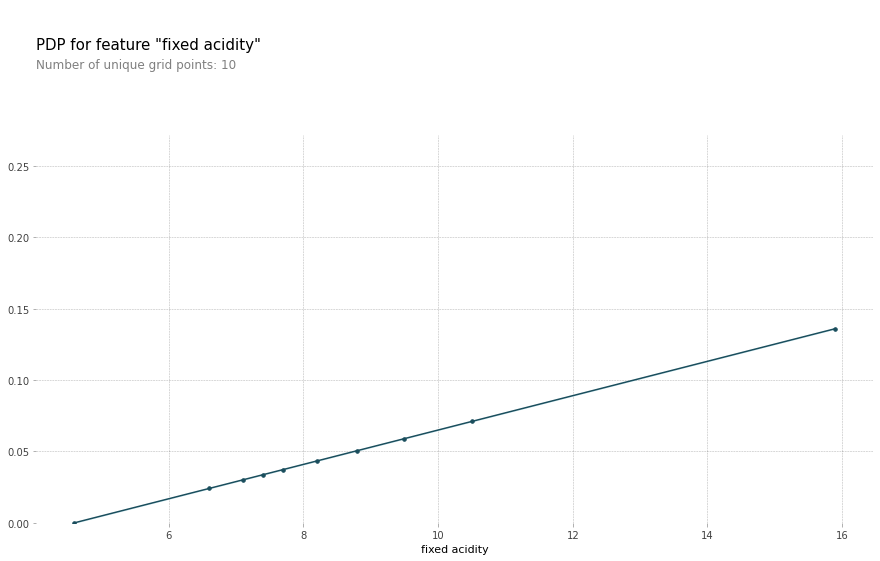

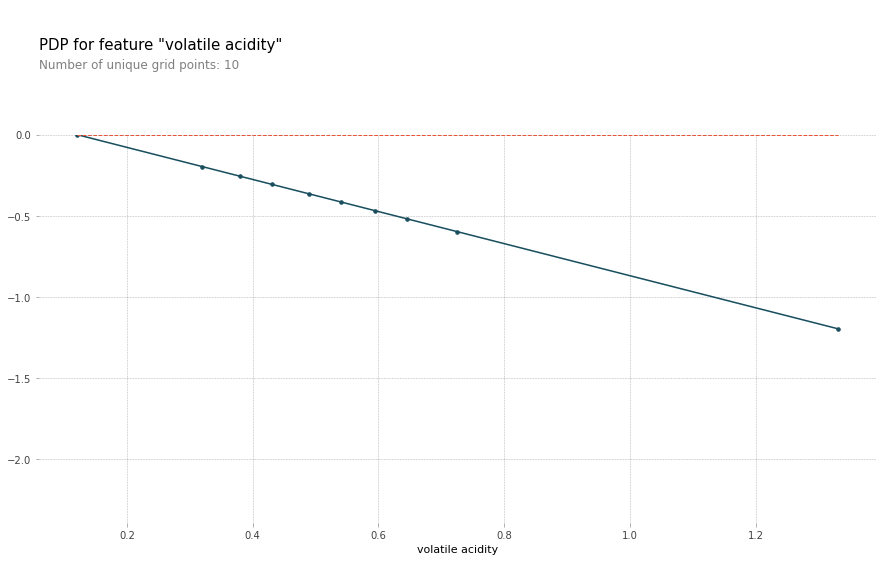

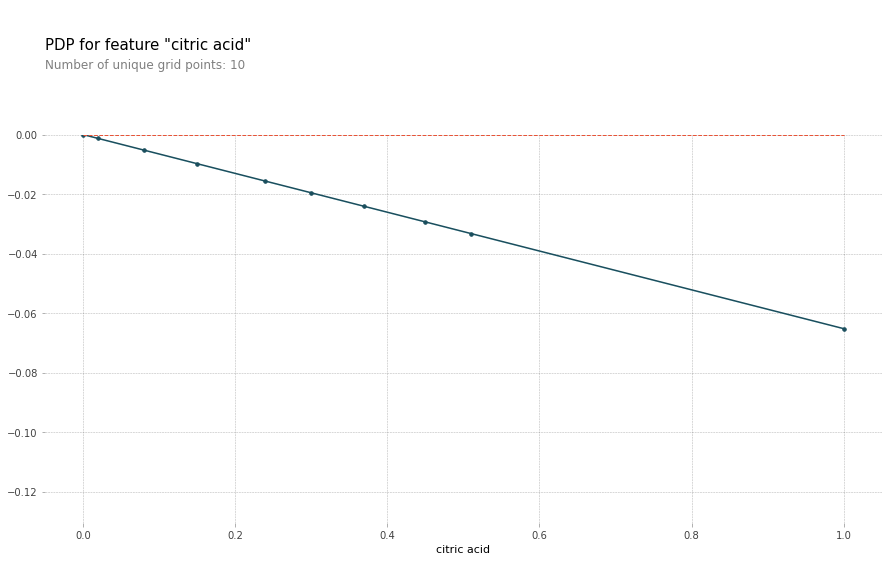

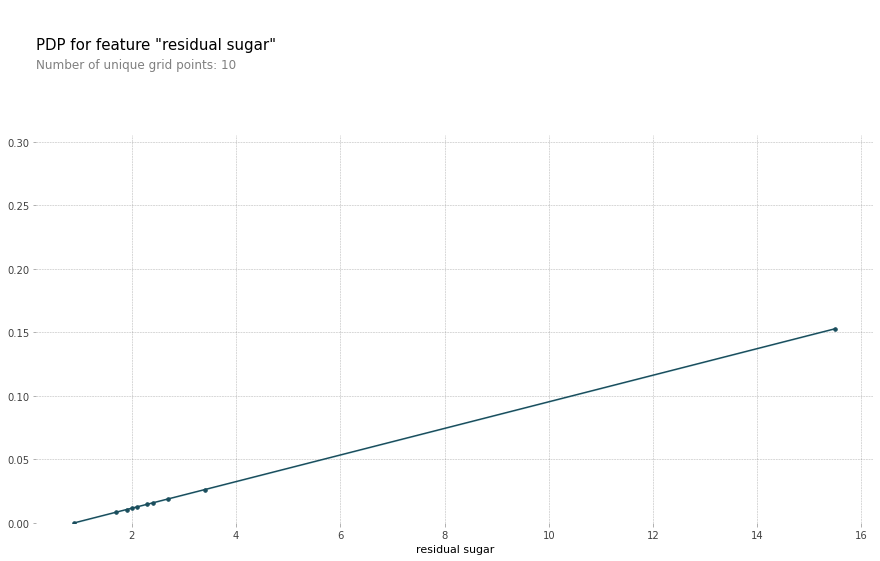

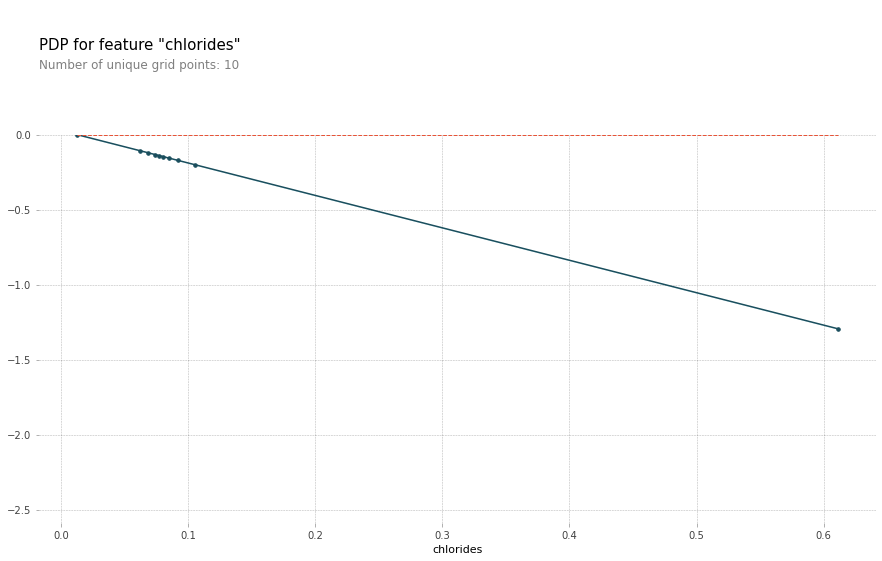

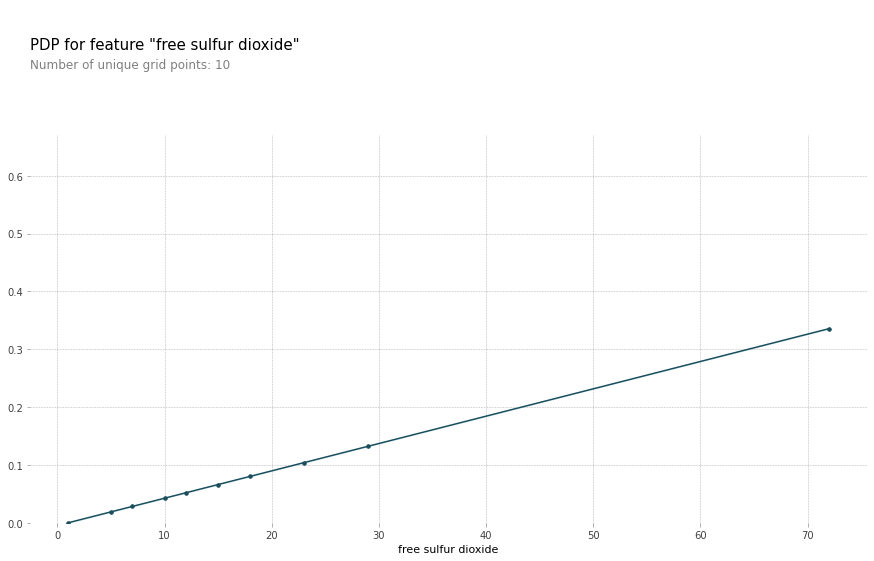

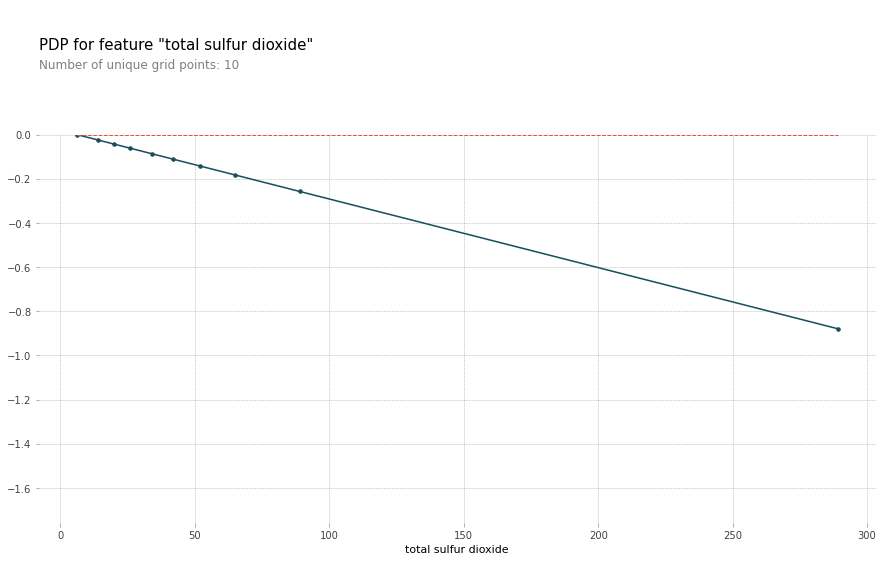

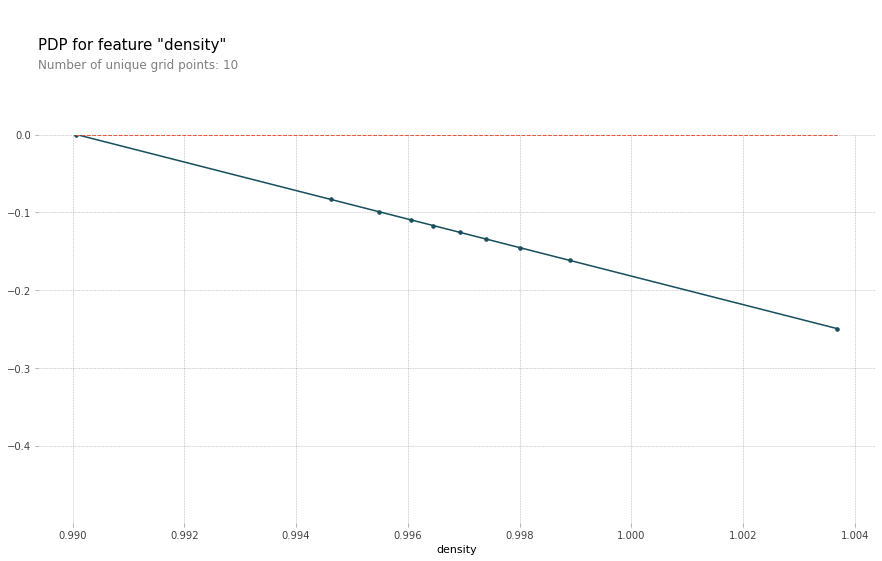

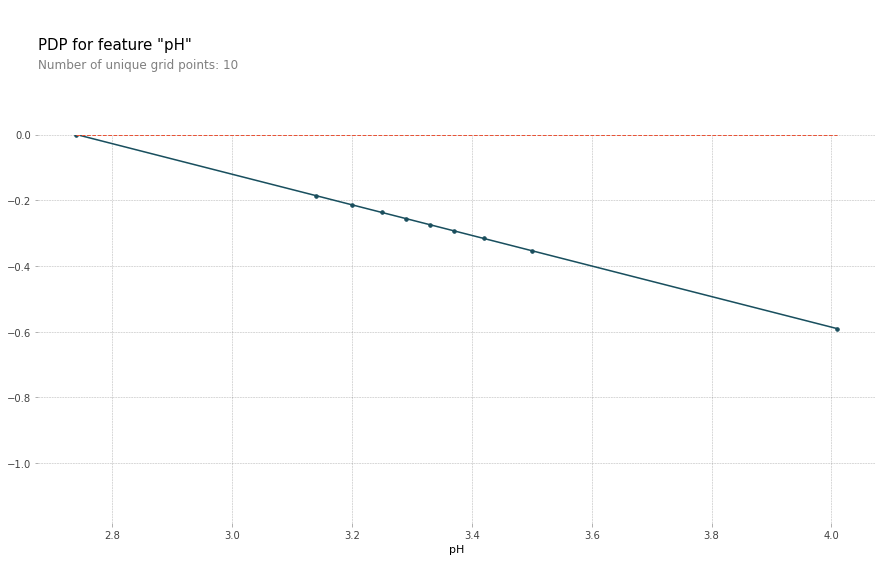

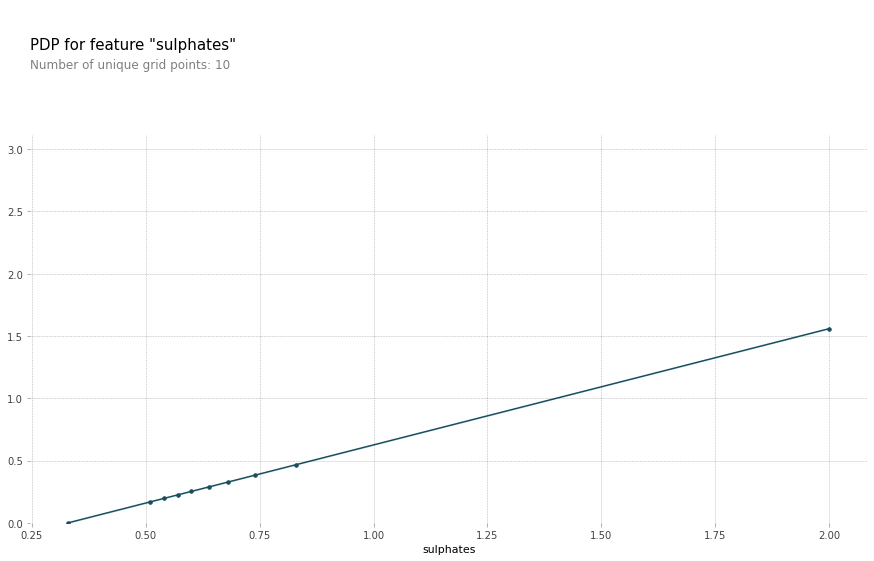

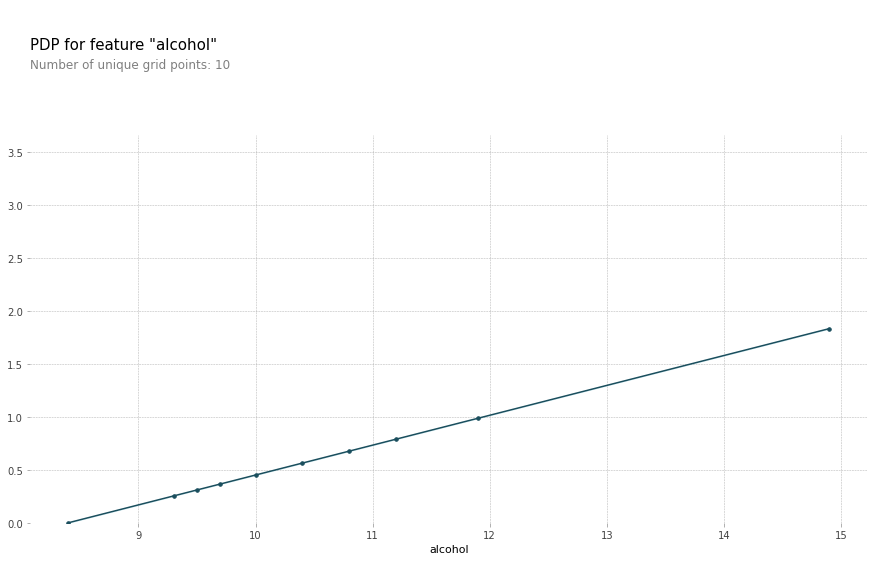

In [15]:
for column in X_train.columns :

  plot_pdp(model, X_train, column)

# ICE

http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html

https://stackoverflow.com/questions/60164019/pycebox-iceplot-does-not-work-on-xgboost-while-work-on-random-forest

In [16]:
!pip install pycebox

  Created wheel for pycebox: filename=pycebox-0.0.1-cp36-none-any.whl size=3644 sha256=b8a531cf834d8242a72318940be980279f49c0e2a9a4b13628428c534b1e45e2
  Stored in directory: /root/.cache/pip/wheels/58/5e/65/001126ca8b1f5c71e9571d09ba579e82bb0792062e7a82e77c
Successfully built pycebox


In [17]:
from pycebox.ice import ice, ice_plot

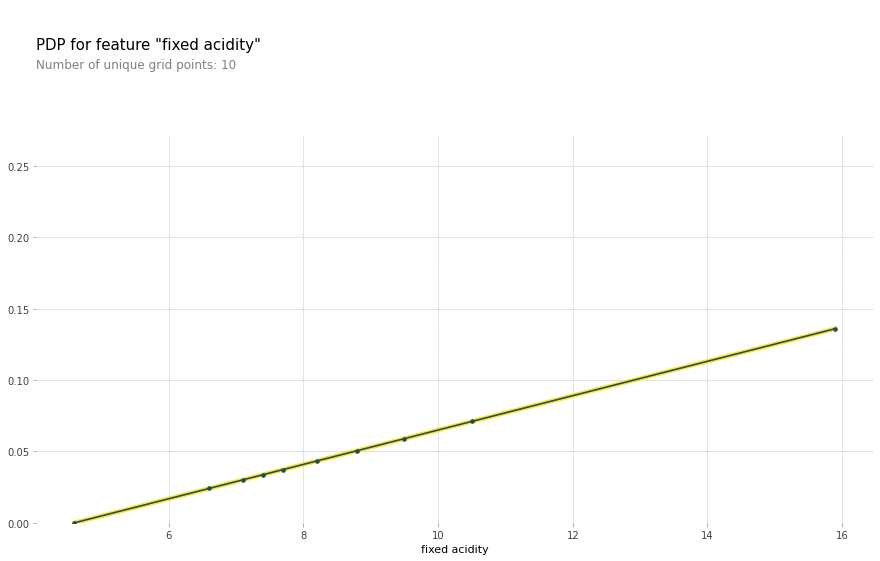

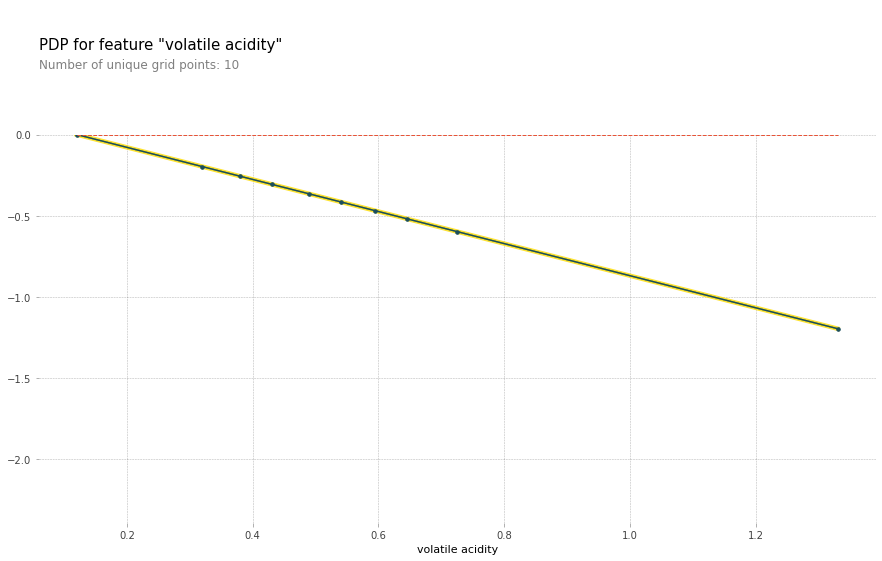

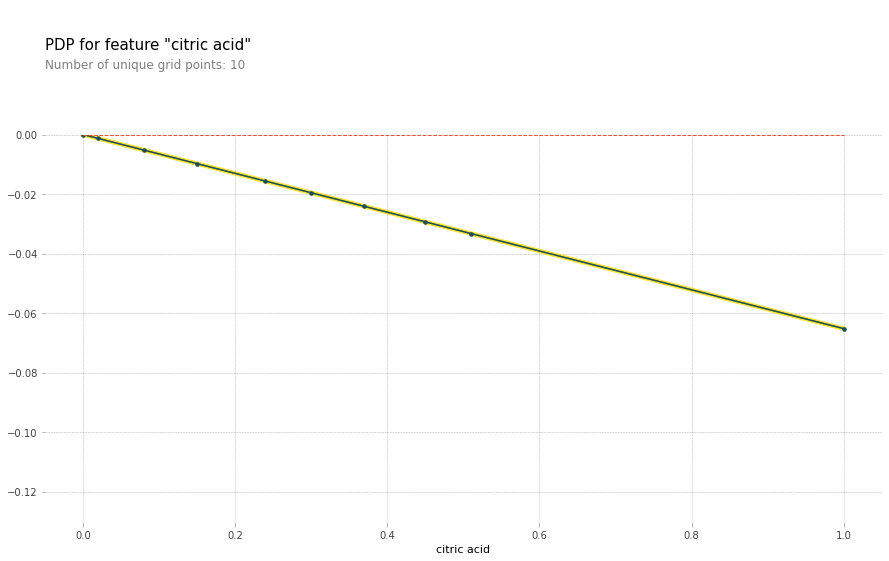

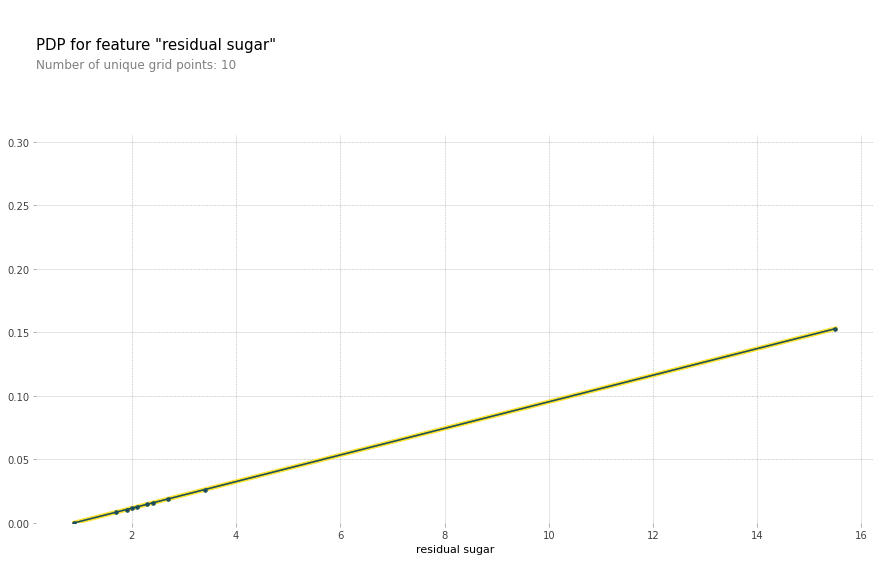

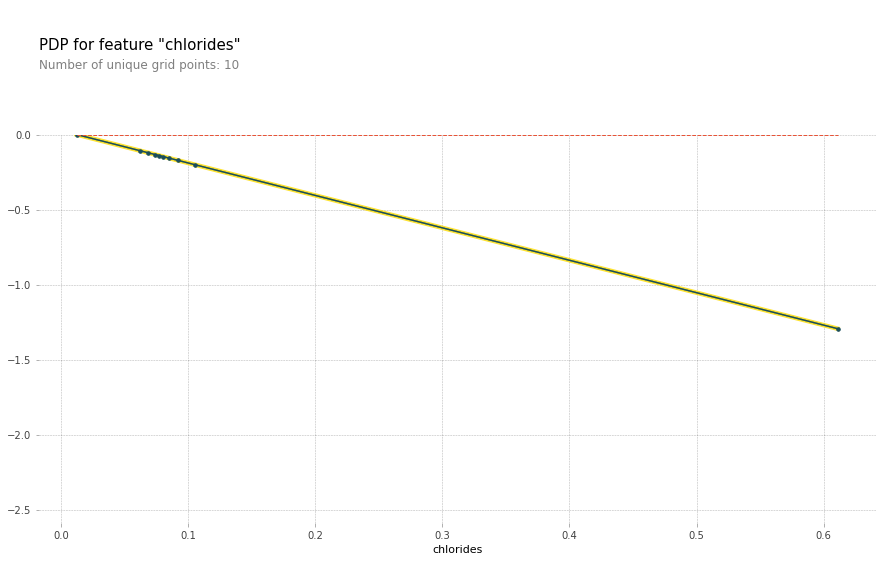

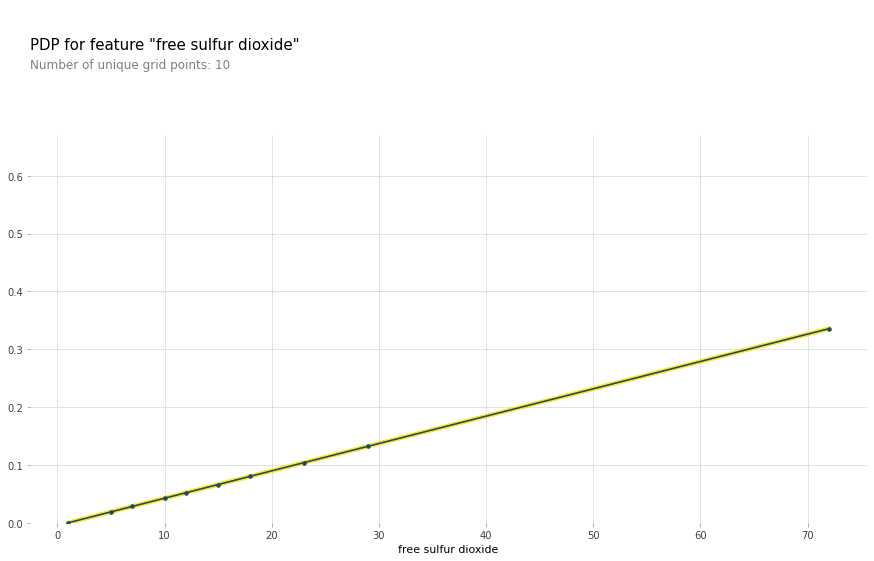

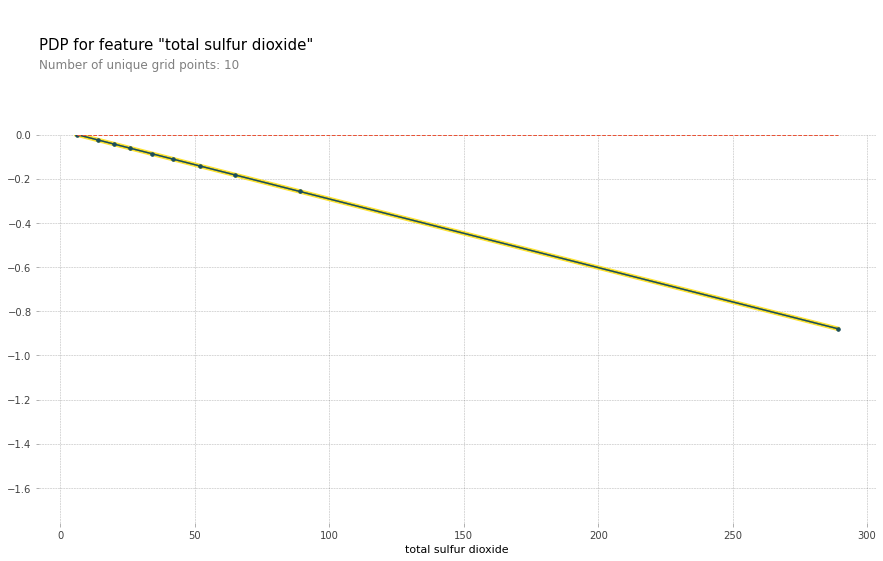

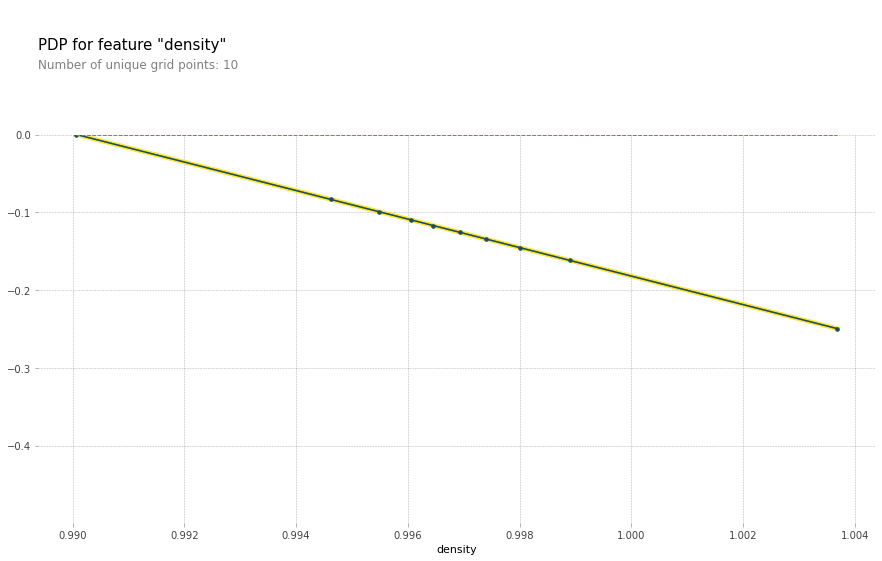

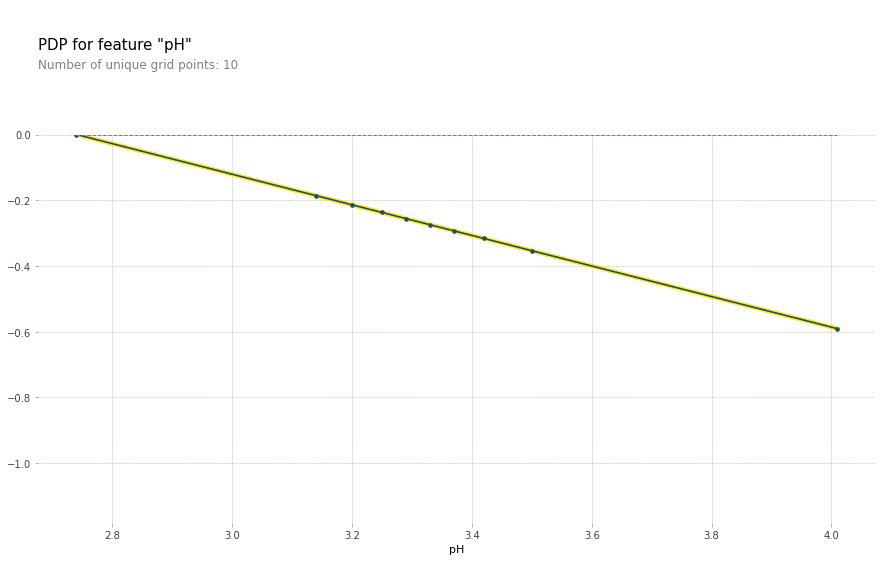

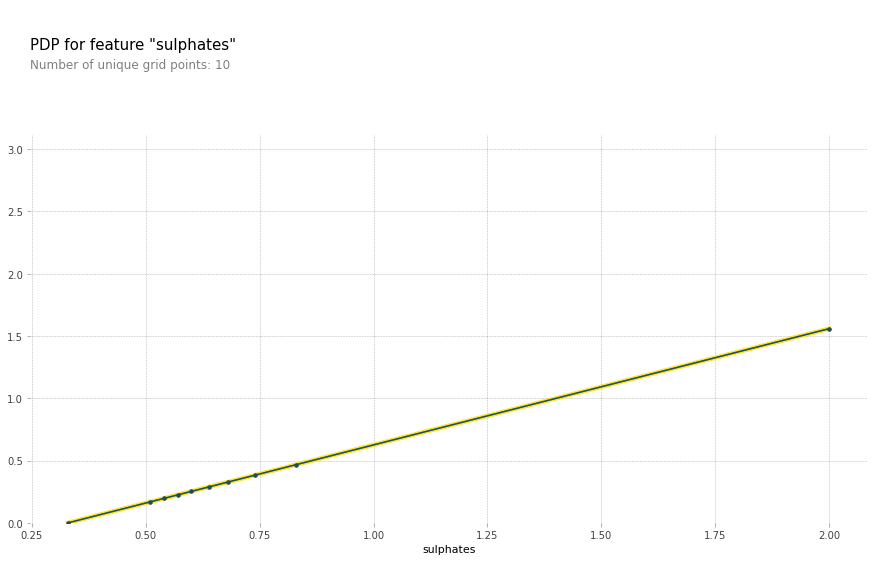

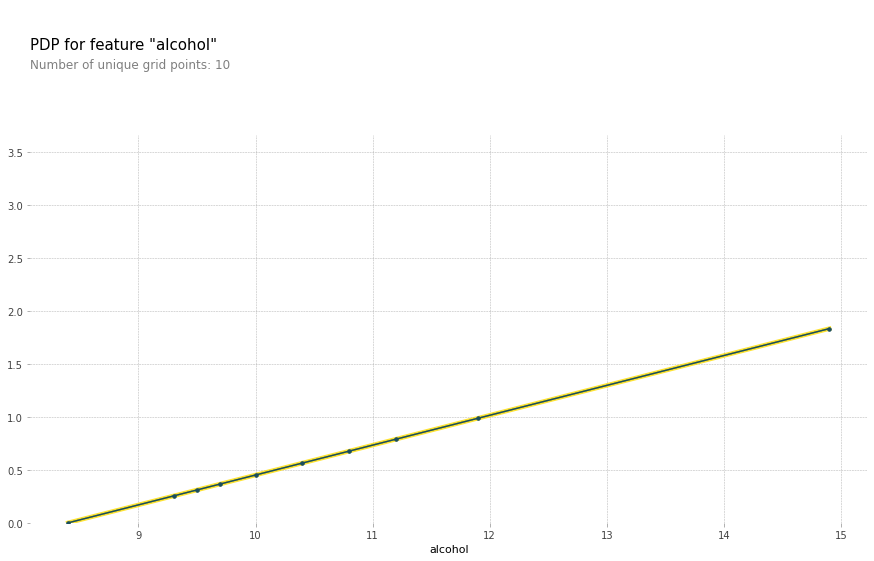

In [18]:
for column in X_train.columns :
  plot_pdp(model, X_train, column, cluster_flag=True, nb_clusters=50, lines_flag=True)

In [ ]:
for column in X_train.columns :

  ice_df = ice(data=X_train, column=column, 
                   predict=model.predict)
  ice_plot(ice_df, c='dimgray', linewidth=0.3)
  ice_plot(ice_df, linewidth=.5, cmap=plt.get_cmap('OrRd'), plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.get_cmap('OrRd')))
  plt.ylabel('Pred. AV %ile')
  plt.xlabel(column);

ValueError: ignored

# Permuation importance

https://www.kaggle.com/dansbecker/permutation-importance

In [19]:
!pip install eli5

     |████████████████████████████████| 112kB 4.8MB/s 


In [20]:
import eli5
from eli5.sklearn import PermutationImportance

In [21]:
perm = PermutationImportance(model, random_state=1).fit(X_test, Y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2684 ± 0.0299,alcohol
0.1410 ± 0.0592,volatile acidity
0.1004 ± 0.0332,sulphates
0.0504 ± 0.0253,total sulfur dioxide
0.0297 ± 0.0094,pH
0.0184 ± 0.0220,chlorides
0.0071 ± 0.0021,fixed acidity
0.0040 ± 0.0164,free sulfur dioxide
0.0013 ± 0.0024,residual sugar
0.0007 ± 0.0026,citric acid


# SHAP

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [22]:
!pip install shap

     |████████████████████████████████| 276kB 4.6MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394118 sha256=cc80be8540c774bf336833f74da483584c2b074bc4b9a3a113fd8105aa8c6211
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [23]:
import shap

In [24]:
train_stats = X_train.describe()
train_stats = train_stats.transpose()

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

df_train_normed = norm(X_train)

In [25]:
df_train_normed_summary = shap.kmeans(df_train_normed.values, 25)

explainer = shap.KernelExplainer(model.predict, df_train_normed_summary)

shap_values = explainer.shap_values(df_train_normed.values)

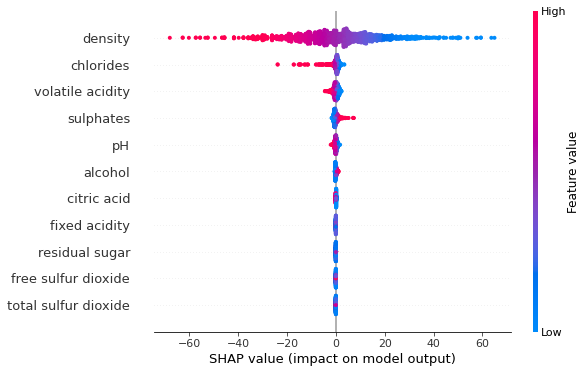

In [26]:
shap.summary_plot(shap_values, X_train)

Dependance plot on SHAP :

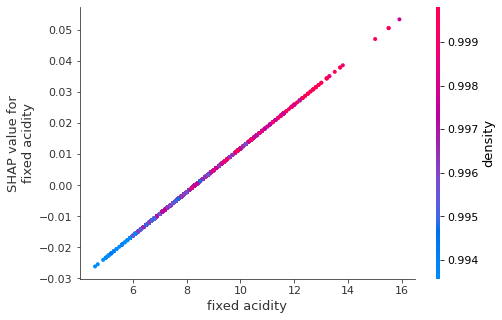

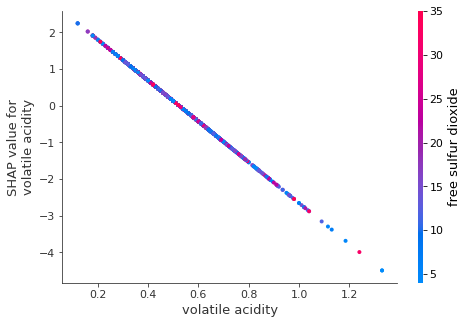

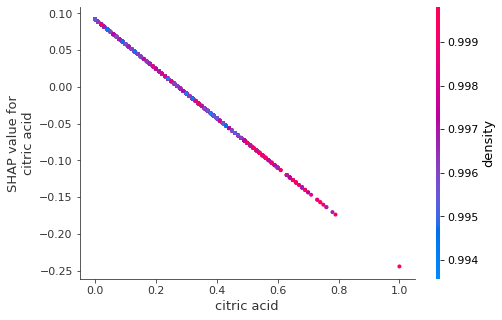

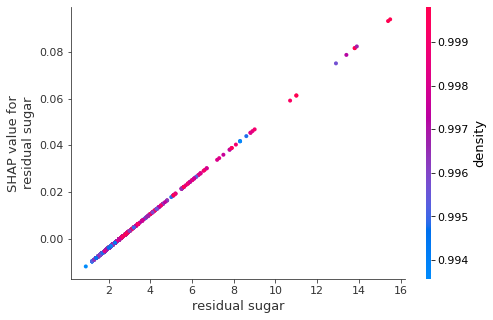

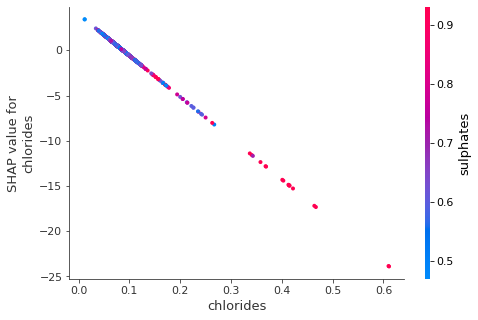

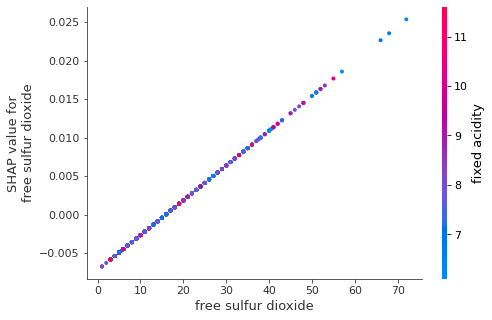

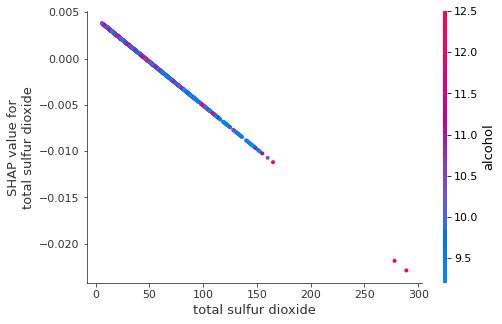

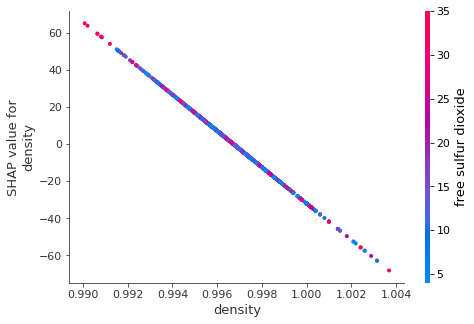

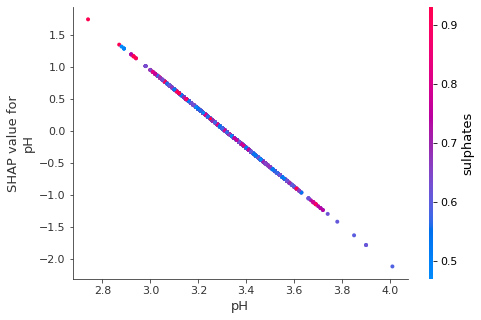

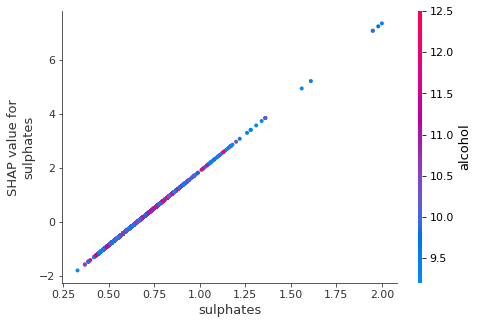

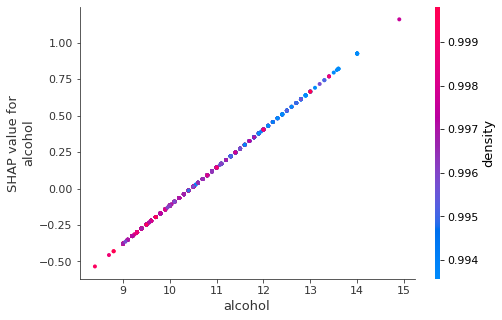

In [27]:
for column in X_train.columns :

  shap.dependence_plot(column, shap_values, X_train)

# Feature importance


https://www.kaggle.com/bersk91/uni-analytics-datadragons/notebook

https://machinelearningmastery.com/calculate-feature-importance-with-python/

https://www.analyticsvidhya.com/blog/2019/08/decoding-black-box-step-by-step-guide-interpretable-machine-learning-models-python/


In [28]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

AttributeError: ignored

# LIME

https://blog.octo.com/introduction-a-linterpretation-de-modeles-de-machine-learning/

In [29]:
!pip install lime

     |████████████████████████████████| 276kB 4.5MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=6d0d5c9b9ee43dfa79f52e76edb34be84e349e46133d2b58bfcfb0e33e6dcc36
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [30]:
import lime
import lime.lime_tabular

In [31]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='regression',training_labels=Y_train, 
                                                   feature_names=df.columns)
explanation = explainer.explain_instance(X_test.values[0], model.predict)
explanation.show_in_notebook()